## A citation map of modern economics


Some useful tools:


* [Metaknowledge](http://networkslab.org/metaknowledge/) which we will use to parse the data from the WebOfScience-data.
* [UMAP](https://github.com/lmcinnes/umap) which we will use for the embedding of the data.
* [hdbscan](https://hdbscan.readthedocs.io/en/latest/index.html) which we will use to do the clustering.


## Literature


* McInnes L, Healy J. *Accelerated Hierarchical Density Based Clustering* In: 2017 IEEE International Conference on Data Mining Workshops (ICDMW), IEEE, pp 33-42. 2017

* McInnes, L, Healy, J, *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*, ArXiv e-prints 1802.03426, 2018

* Reid McIlroy-Young, John McLevey, and Jillian Anderson. 2015. *metaknowledge: open source software for social networks, bibliometrics, and sociology of knowledge research.* URL: http://www.networkslab.org/metaknowledge.








In [18]:
import metaknowledge as mk
import pandas as pd
import numpy as np
from random import randint
import datetime
import scipy as scipy

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

#For Tables:
from IPython.display import display
from IPython.display import Latex
pd.set_option('display.max_columns', 500)

#For R (ggplot2)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Load the WOS-data:

In [19]:
date_string = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")


RC = mk.RecordCollection("quart_econ")


In [20]:
# print(RC.glimpse())
RC2 = mk.RecordCollection()

for R in RC:
    randnr = randint(0, 4)
    
    if len(R.getCitations().get("author"))>=1: # and randnr==0 apply condition in order to downsample records
        #Here we kick out every paper that cites less then 3 authors. Why? because they
        #are so dissimilar from the others, that they only produce noise.  
   
        try:
            R['year']
            #if R['year']>1961:
            #R['abstract']  #Add this when working with abstracts. It removes every paper that has none. 
            #This can sometimes remove whole journals, that are archived without abstracts, so handle with care.
            RC2.add(R)
        except KeyError:
            pass
    else:
        pass
    

print(RC2.glimpse())


RC = RC2


RecordCollection glimpse made at: 2018-10-08 17:56:54
2934 Records from Empty

Top Authors
1 STIGLITZ, JE
2 SAMUELSON, PA
3 AKERLOF, GA
4 Saez, Emmanuel
5 Acemoglu, D
5 SHESHINSKI, E
5 Mullainathan, Sendhil
6 Glaeser, EL
6 BAUMOL, WJ
6 WEITZMAN, ML
6 Shleifer, Andrei
6 MURPHY, KM
6 Shleifer, A
6 MANKIW, NG
6 GROSSMAN, GM
7 KRUEGER, AB
7 Duflo, Esther
7 Veblen, Thorstein
7 FELDSTEIN, M
7 Isard, Walter
7 STEIN, JC
7 SMITH, VL

Top Journals
1 QUARTERLY JOURNAL OF ECONOMICS

Top Cited
1 KATZ LF, 1992, Q J ECON, V107, P35, DOI 10.2307/2118323
2 LUCAS RE, 1988, J MONETARY ECON, V22, P3, DOI 10.1016/0304-3932(88)90168-7
3 KAHNEMAN D, 1979, ECONOMETRICA, V47, P263, DOI 10.2307/1914185
4 BARRO RJ, 1991, Q J ECON, V106, P407, DOI 10.2307/2937943
4 ROMER PM, 1986, J POLIT ECON, V94, P1002, DOI 10.1086/261420
4 GROSSMAN SJ, 1986, J POLIT ECON, V94, P691, DOI 10.1086/261404
5 Laibson D, 1997, Q J ECON, V112, P443, DOI 10.1162/003355397555253
6 Melitz MJ, 2003, ECONOMETRICA, V71, P1695, DOI 10.1111/

Above we have some statistics about the data we are working with. We have lost roughly 2000 records where data was missing. The summaries show us the most prolific authors, the journals with the most occurences and the most cited single works. All of this makes sense so far. We have the incredibly popular David Lewis with multiple mentions in the the the top cited works, along with some other very well known recent authors, and of course the most influential of classics, Aristotle & Hume.


### Extracting the Features

In order to use UMAP and the clustering algorithm, we have to extract some features to work with. 

I have chosen to use two kinds:
+ cited works *and*
+ cited authors

*Cited works* are the precise citation string that the WOS-Collection uses. These are very good to get the fine-grained structure of the literature, as they can be very specific. They allow us for example to differentiate between the epistemologic and the political works of Robert Nozick. Cited authors on the other hand are to a certain extent redundant, as they are only a less precise form of cited works. 
But they are valuable for us, as they give us a general corner in which a paper belongs. This allows us to use much more of our data, as relying only on cited works forces us to kick out many papers that are only weakly linked to the rest. 
I have done some experiments with various combinations of vectorizations (author, work, words in abstract, title, etc.) and their combinations on labeled data, and the results of combining works and authors seems to work best. Look here for a little [*proof of concept*](https://github.com/MNoichl/Proof-of-concept-for-literature-clustering-with-UMAP-HDBSCAN/blob/master/proof_of_concept.ipynb) that shows how well we can differentiate different disciplines.

Both types of features are extracted with scikit-learn and concatenated. Than we filter out everything that is weakly linked, as it tends to "ball up" in the UMAP without containing useful information.

In [21]:
########### Cited Works - Features ############

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
drc = pd.DataFrame.from_dict(RC.forNLP(extraColumns=['journal','AU','FU','PD']))

d = []
citedAU = []
citestring =[]
for R in RC:

    d.append(list(set(R.getCitations().get("citeString")))) #To cluster by cited author
    citedAU.append(list(set(R.getCitations().get("author"))))
    citestring.append(list(set(R.getCitations().get("citeString"))))

drc["citedAU"] = citedAU
drc["citestring"] = citestring
#print(d[0])
authorslist = ['§'.join(filter(None,x)) for x in list(d)] 
#print(authorslist[0])

# vec = TfidfVectorizer(token_pattern=r'(?<=[^|§])[\s\w,\.:;]+(?=[$|§])')
vec = CountVectorizer(token_pattern=r'(?<=[§])[\s\w,\.:;\/\[\]-]+(?=[§])',binary=True, min_df = 3)#, min_df = 1)


Xrc = vec.fit_transform(authorslist)

In [22]:
########### Authors - Features ############

d = []
for R in RC:
    authors = list(set(R.getCitations().get("author")))
#    print(authors)
    authors = filter(None, authors)
    f = []
    for a in authors:
        f.append(' '.join([w for w in a.split(' ')if len(w)>2]))
        
    authors = f#' '.join(f)
    d.append(authors)
authorslist = [';'.join(filter(None,x)) for x in list(d)] 
vec = CountVectorizer(token_pattern=r'(?<=[;])[\s\w]+(?=[;])',binary=True, min_df = 10)

XrcAu = vec.fit_transform(authorslist)

In [23]:
k = [Xrc]#XrcAu,
XrcFull = scipy.sparse.hstack(k).tocsr()

In [24]:
###### Filtering #######
from scipy.sparse import coo_matrix, vstack
from scipy.sparse import csr_matrix
import scipy as scipy
row_names = np.array(drc["id"])

newdf=[]
a = 0
# index by name:
for x in range(0,XrcFull.shape[0]): #Xrc.shape[0]):
    row_idx, = np.where(row_names == drc["id"][x])
    if np.diff(XrcFull[row_idx].tocsr().indptr) >= 3:
        if a == 0:
            k = [XrcFull[row_idx]]
        if a != 0:
            k.append(XrcFull[row_idx])
        a = a+1
        newdf.append(drc.loc[x])
        
drc = pd.DataFrame(newdf).reset_index()
M = scipy.sparse.vstack((k))

In [25]:
print(len(drc))

1447


In [29]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=50, n_iter=7, random_state=42)

XSVD = SVD.fit_transform(M)
print(SVD.explained_variance_ratio_.sum())
dSVD = pd.DataFrame(XSVD)

sSVD = dSVD[[0,1]]
sSVD.columns = ['x','y']

0.20845530267293252


### Now for the [UMAP](https://github.com/lmcinnes/umap)

Umap is pretty young technique for dimensionality reduction, which has the big advantage of beeing pretty fast. And it seems to preserve global structure quite reliably, which is nice, as it enables us to cluster afterwards.
We will plot the 2D-embedding with ggplot, so that we have something to look at:

In [66]:
import umap

try:
    drc = drc.drop('x',axis=1)
    drc = drc.drop('y',axis=1)

except KeyError:
    pass


embedding = umap.UMAP(n_neighbors = 10,#small => local, large => global: 5-50
                      min_dist = 0.05, #small => local, large => global: 0.001-0.5
                      spread = 1.7,
                      metric='cosine').fit_transform(XSVD)
embedding = pd.DataFrame(embedding)
embedding.columns = ['x','y']


C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


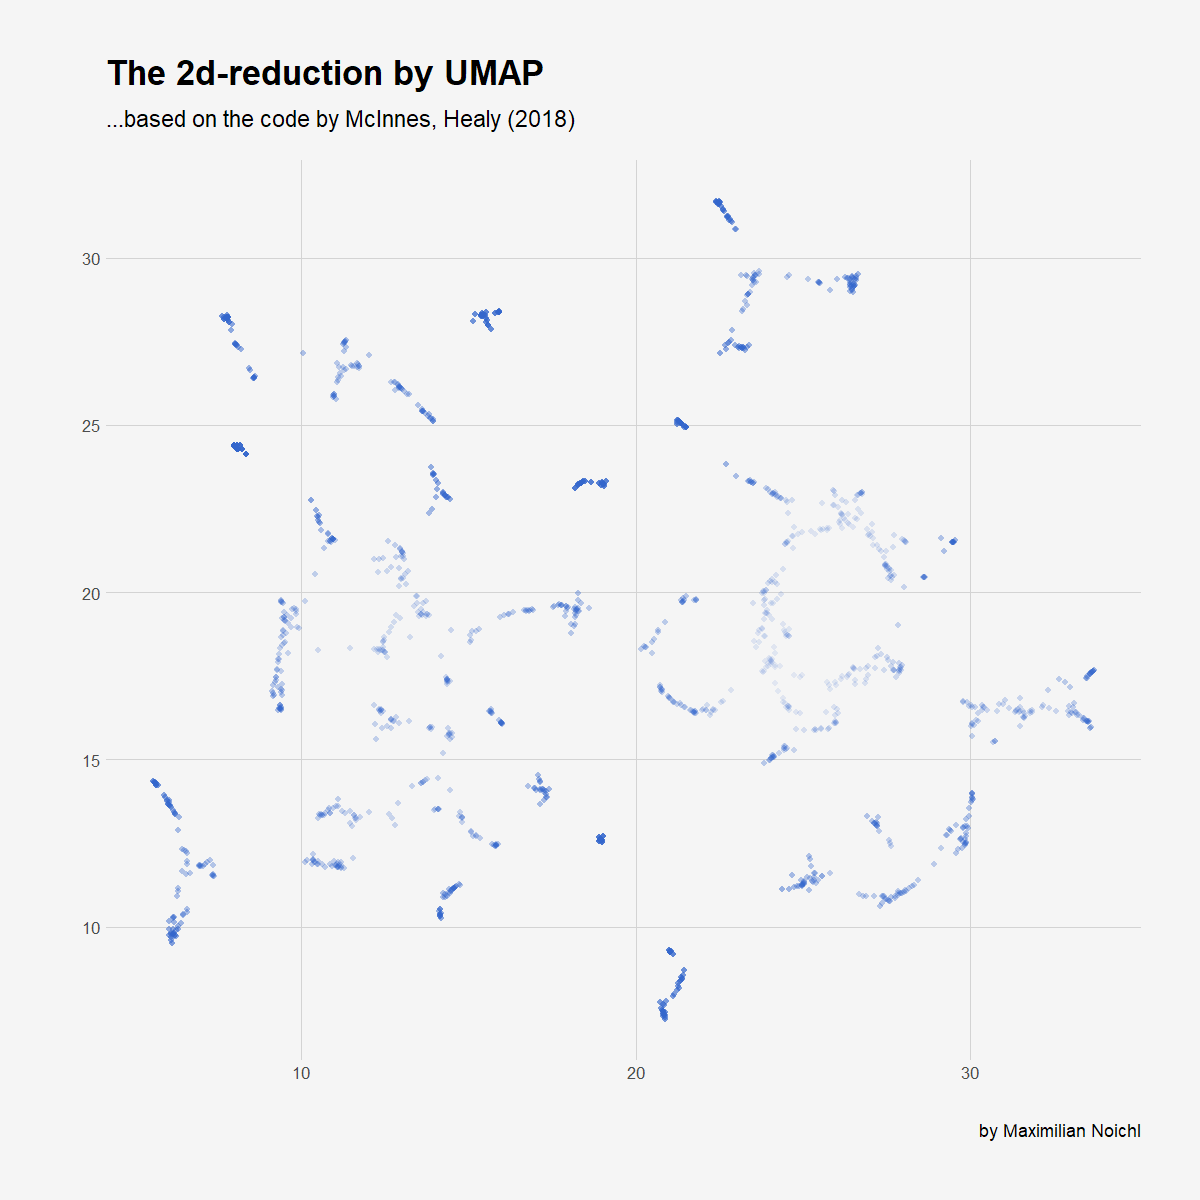

In [67]:
%%R -i embedding --width 1200 --height 1200 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y,alpha = 1/density))+

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
coord_fixed()+
labs(x="", y="",
       title="The 2d-reduction by UMAP",
       subtitle="...based on the code by McInnes, Healy (2018)",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank()
)
p


In [33]:
drc['timestamp'] = drc["year"] + drc["PD"].fillna(0).replace('', 0, regex=True)/12

In [49]:

n_neighbors = 7
embeddingI = umap.UMAP(n_components=1,
                        n_neighbors=n_neighbors,
                      min_dist=0.008,
                       spread = 0.8,
                      metric='cosine').fit(XSVD)

# coordinates = []
# for year in range(int(drc["year"].min()),int(drc["year"].max())):
#     l = list(np.where(drc["year"] == year)[0])
#     L = XSVD[l]     

#     emb = embeddingI.transform(L)
#     emb = pd.DataFrame(emb)
#     emb.columns = ['xI']

#     emb["year"] = drc.iloc[l,:]["timestamp"].tolist()
#     coordinates.append(emb)

# coordinates = pd.concat(coordinates, ignore_index=True)

embeddingI = pd.DataFrame(embeddingI.embedding_)
embeddingI.columns = ['xI']
embeddingI["year"] = drc["timestamp"].tolist()


In [50]:
print(embeddingI)

             xI         year
0      6.866539  1978.000000
1      6.569211  2000.916667
2     13.167196  1990.166667
3      5.324471  2013.166667
4     10.241682  2006.416667
5     18.956068  2004.916667
6      7.437755  1980.000000
7     16.086435  1980.000000
8     20.368355  1972.000000
9      9.636624  2006.666667
10    14.550719  1960.000000
11    23.024311  1996.166667
12    36.501236  1986.166667
13    15.349582  1972.000000
14    35.597225  2003.166667
15    32.717098  2016.666667
16    25.371218  1991.666667
17    11.628154  1980.000000
18    15.311761  1990.666667
19    20.973026  1976.000000
20    -8.468710  2015.916667
21    29.904772  2005.166667
22    26.880234  1974.000000
23     3.551496  1993.666667
24    32.706047  1986.916667
25     2.781881  2012.666667
26    27.375240  2016.166667
27    25.081564  1997.666667
28    20.933376  2010.666667
29    11.738056  1994.916667
...         ...          ...
1417  14.643856  1983.000000
1418   6.867211  1971.000000
1419  36.68175

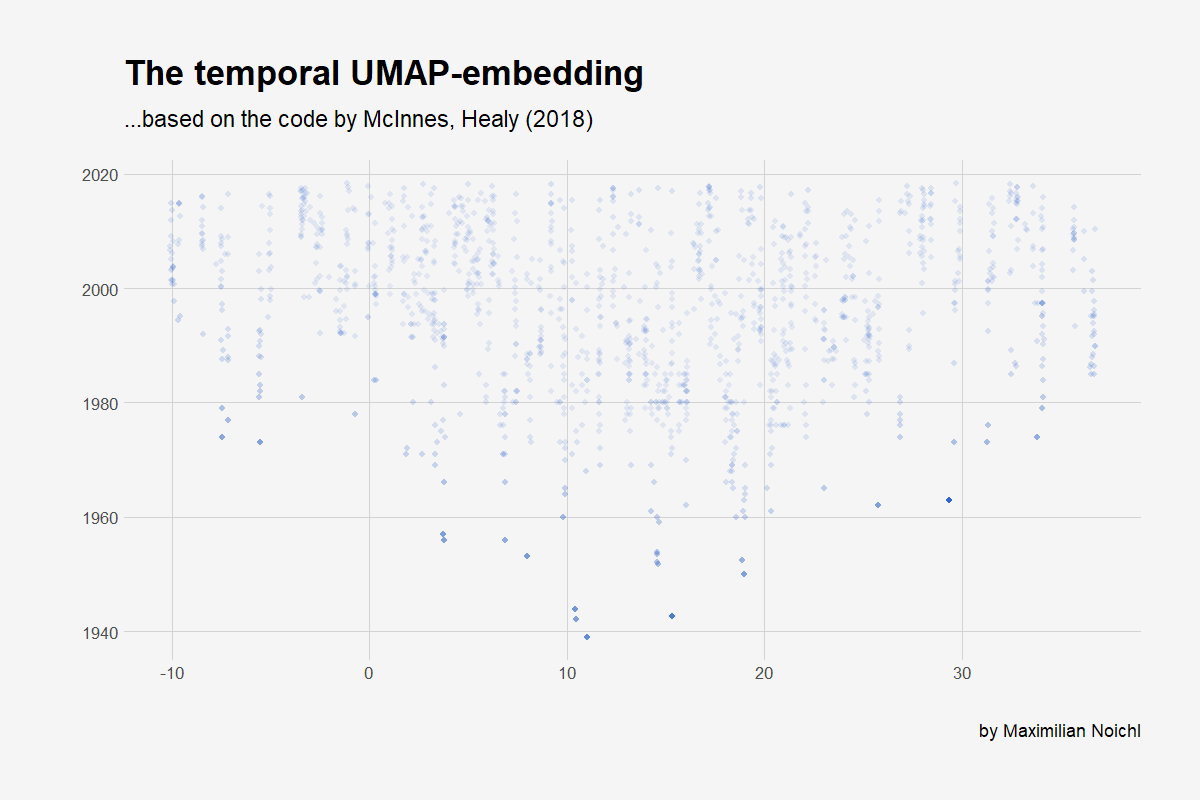

In [53]:
%%R -i embeddingI --width 1200 --height 800 -r 140 --bg #F5F5F5
library(hrbrthemes)
library(ggplot2)
library(fields)
embeddingI$density <- fields::interp.surface(
  MASS::kde2d(embeddingI$xI, embeddingI$year), embeddingI[,c("xI","year")])

p <- ggplot(embeddingI, aes(x=embeddingI$xI, y=embeddingI$year,alpha =1/density))+#1/density

 guides(alpha=FALSE)+

geom_point(color="#3366cc", pch=16,cex=1.2)+ theme_ipsum_rc()+
labs(x="", y="",
       title="The temporal UMAP-embedding",
       subtitle="...based on the code by McInnes, Healy (2018)",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank()
)
p


As you can see, the web of science started to archive the *months* of publishing only in the late eighties, which is why the plot has these lines at the bottom, where we can assign only years to the publications. 

### Clustering with [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan)

Now we use HDBSCAN to cluster our data:


In [69]:
try:
    drc = drc.drop('cluster',axis=1)
except KeyError:
    pass

import hdbscan

#(min_cluster_size=500, min_samples=30, gen_min_span_tree=True)
#clusterer = hdbscan.HDBSCAN(min_cluster_size=455, min_samples=35, gen_min_span_tree=True)

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=40, gen_min_span_tree=True)
clusterer.fit(embedding)
XCLUST = clusterer.labels_
clusternum = len(set( clusterer.labels_))-1


dfclust = pd.DataFrame(XCLUST)
dfclust.columns = ['cluster']


print(clusternum)
### Let's play a little sound when we're done:
# import winsound
# winsound.Beep(550,300)

6


Now lets plot everything in ggplot:

C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


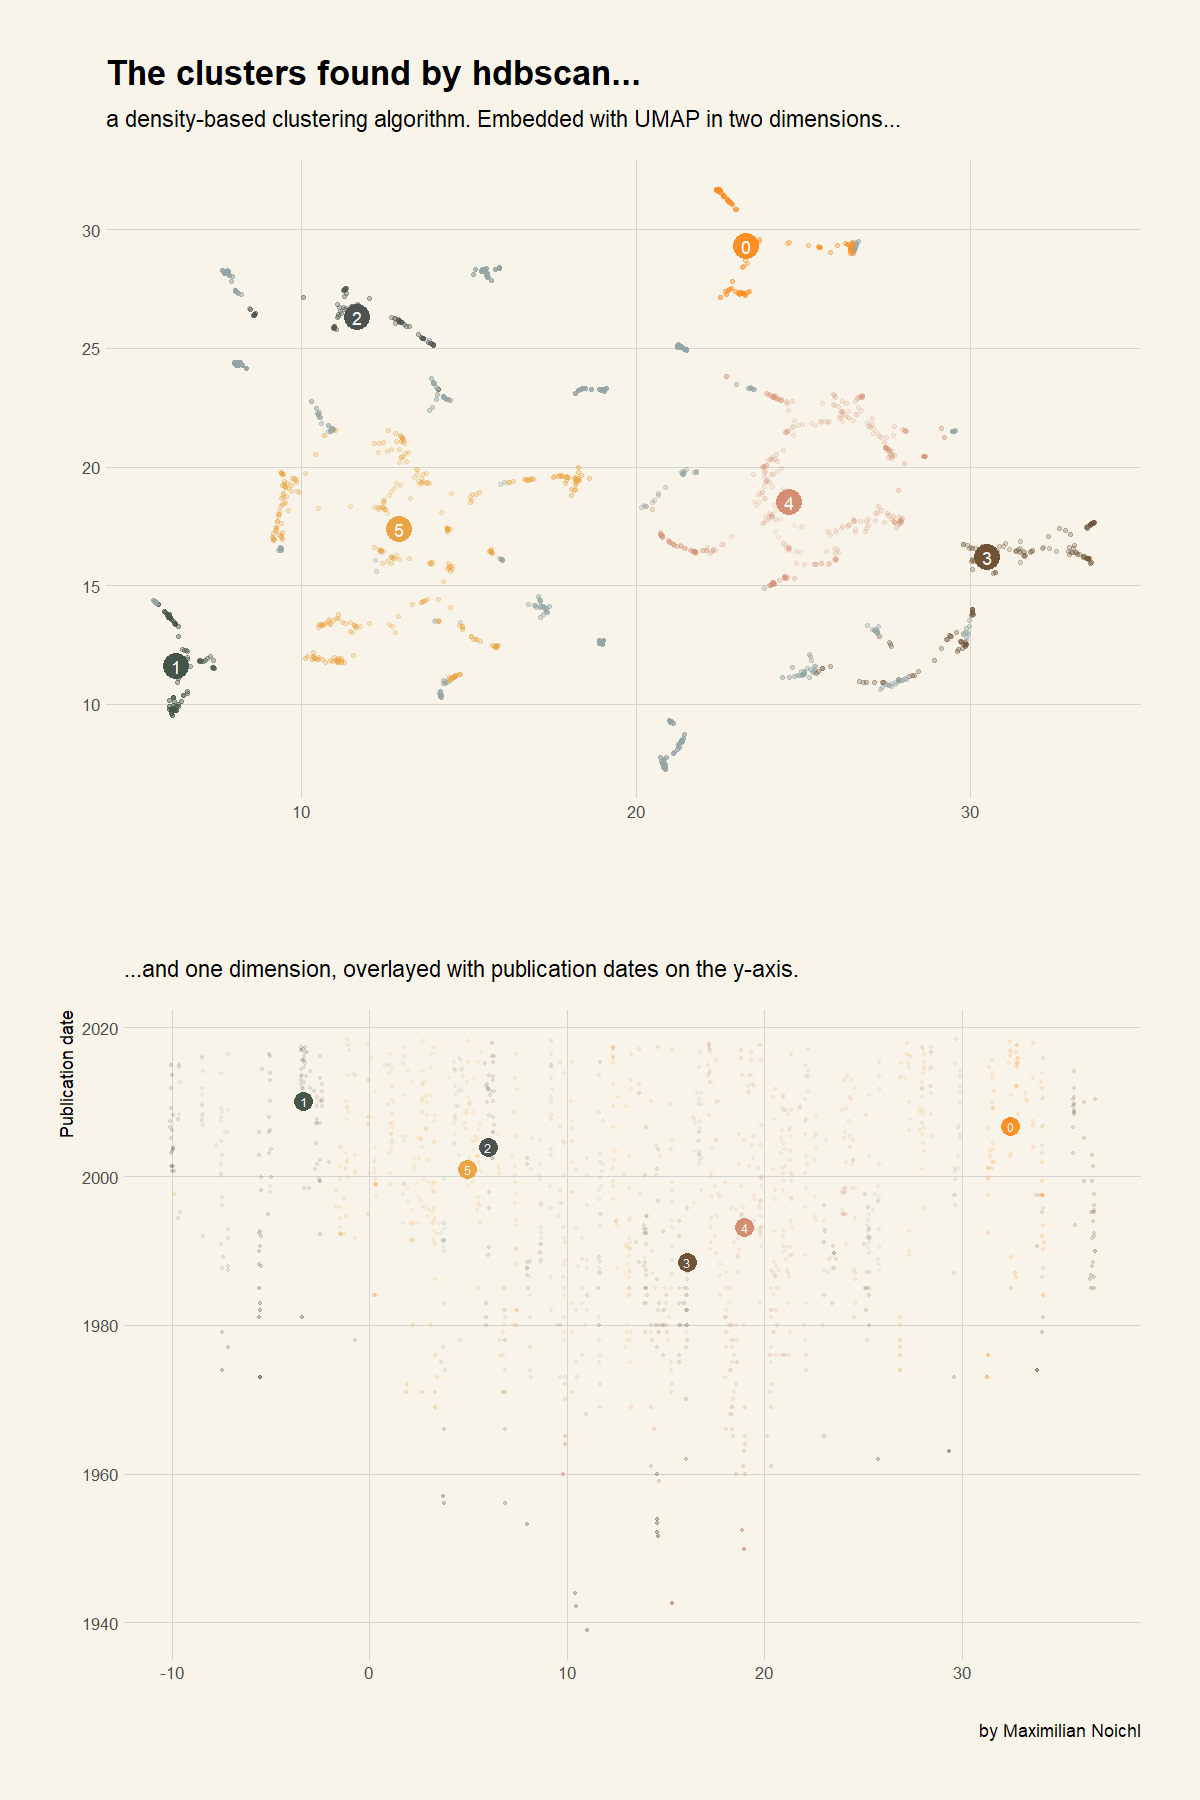

In [70]:
%%R -i embedding,dfclust,embeddingI -o myNewColors,tmeans --width 1200 --height 1800 -r 140 --bg #F8F4E9

library(hrbrthemes)
library(ggplot2)
library(fields)
library(plyr)
options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), median)
means <- data.frame(means) 
n=nrow(means)
means <- means[-1,]

#Make the colors: 
mycolors <- c("#c03728","#919c4c","#fd8f24","#f5c04a","#e68c7c","#00666b","#142948","#6f5438") 

pal <- colorRampPalette(sample(mycolors))
s <- n-1
myGray <- c('#95a5a6')
myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)

#get temporal means:
tmeans <- aggregate(embeddingI[,c("xI","year")], list(dfclust$cluster), median)
tmeans <- data.frame(tmeans) 
tmeans <- tmeans[-1,]




#get density, to avoid overplotting
embedding$density <- fields::interp.surface(
  MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")])

#get temporal density
embeddingI$density <- fields::interp.surface(
  MASS::kde2d(embeddingI$xI, embeddingI$year), embeddingI[,c("xI","year")])


p <- ggplot(embedding, aes(x=embedding$x, y=embedding$y, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.6)+ 
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
 guides(alpha=FALSE, color=FALSE)+
geom_point(data=means, aes(x=means$x, y=means$y), color= myNewColors, alpha = 1,size =6)+
annotate("text", x = means[,c("x")], y = means[,c("y")], label = means[,c("Group.1")], color="white", fontface="bold",  size=3.2, parse = TRUE, hjust=0.5)+
labs(x="", y="",
       title="The clusters found by hdbscan...",
       subtitle="a density-based clustering algorithm. Embedded with UMAP in two dimensions...")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


t <- ggplot(embeddingI, aes(x=embeddingI$xI, y=embeddingI$year, color= as.factor(dfclust$cluster), alpha = 1/density))+
geom_point(pch=20,cex=1.2)+
theme_ipsum_rc()+
scale_color_manual(values = myPal) +
guides(alpha=FALSE, color=FALSE)+
geom_point(data=tmeans, aes(x=tmeans$x, y=tmeans$y), color= myNewColors, alpha = 1,size =4.2)+
annotate("text", x = tmeans[,c("xI")], y = tmeans[,c("year")], label = tmeans[,c("Group.1")], color="white", fontface="bold",  size=2.2, parse = TRUE, hjust=0.5)+
labs(x="", y="Publication date",
         subtitle="...and one dimension, overlayed with publication dates on the y-axis.",
       caption="by Maximilian Noichl")+
theme(panel.grid.major = element_line(colour = "lightgrey"),panel.grid.minor = element_blank())


library(gridExtra)
grid.arrange(p,t, ncol = 1,  heights = c(1, 1))

# pdf("ClusteringUMap.pdf", width = 12, height = 12) # Open a new pdf file
# grid.arrange(p,t, ncol = 1,  heights = c(1, 1)) # Write the grid.arrange in the file\n",
# dev.off()



Thats nice. To have look into the way the clustering algorithm has structured the data, lets look at the condensed tree.  
I messed around a bit in my installation of HDBSCAN, so if you run this on your computer, your tree will propably look quite different.
The condensed clustering tree basically tells us, when the algorithm found it necessary to break a group apart into two smaller clusters. On the left of the tree we see the clusters that were so far removed from the central structure, that they broke off at the very beginning of the clustering process.

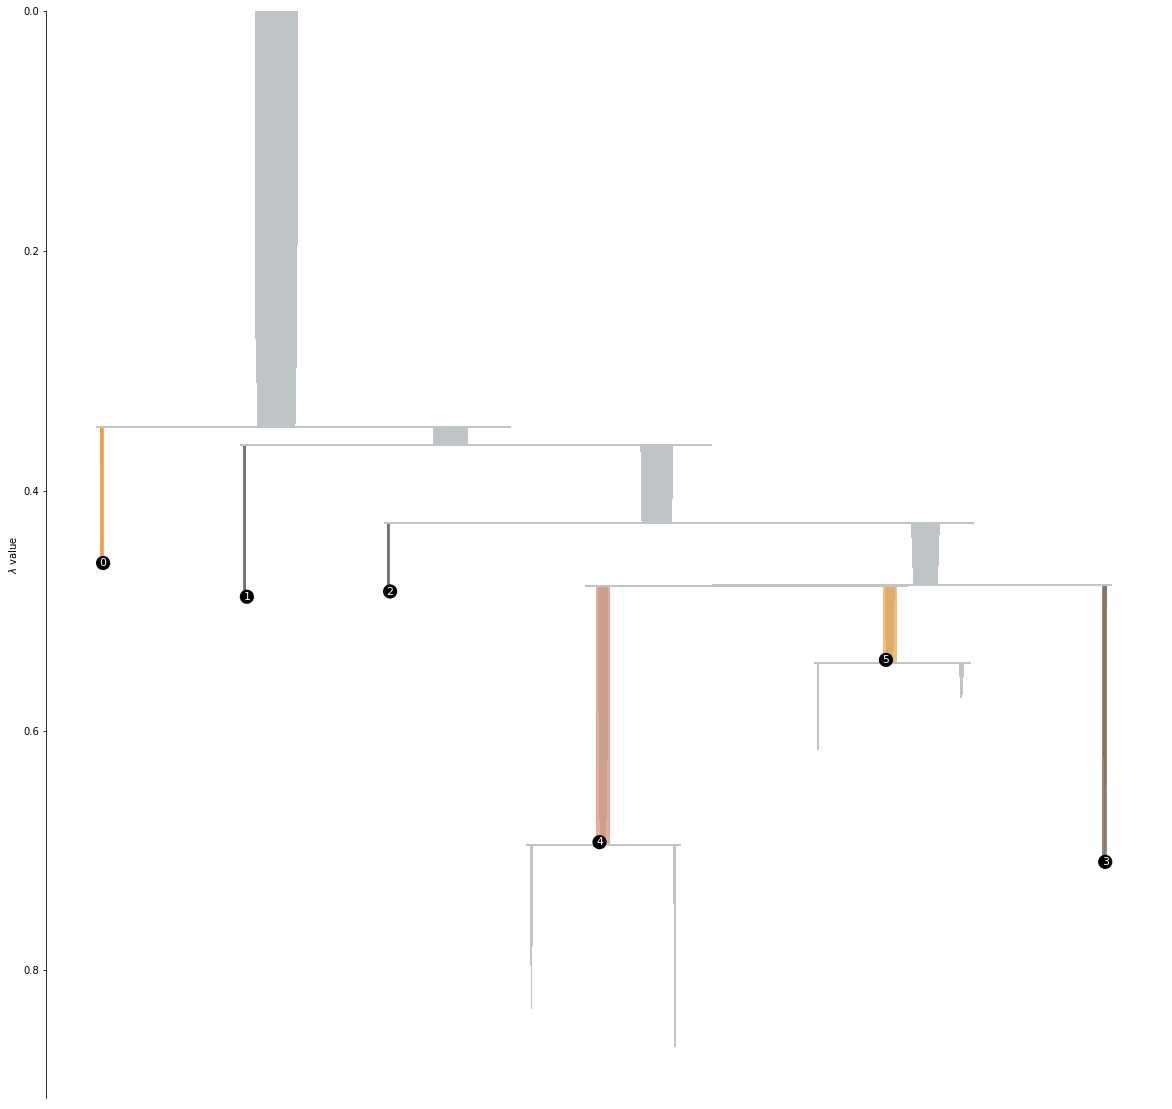

In [71]:
import matplotlib.colors
plt.rcParams['figure.figsize'] = [20, 20]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#bfc4c6","#bfc4c6","#bfc4c6"])

clusterer.condensed_tree_.plot(cmap = cmap,select_clusters=True,label_clusters = True, selection_palette=myNewColors, 
                               colorbar = False,max_rectangles_per_icicle=80, alpha=0.7,barwidthfactor=0.3,linecolor='#bfc4c6',linewidth=2)


### What does it mean?
Now, let us look into the clusters, to find out what they actually contain. First we shall analyze the abstracts of the papers in every cluster according to their most common words and bigrams. In the tables below, every column is a cluster, and every row is a common word. Then we will do the exact same thing with the most cited authors.

In [72]:

drc = pd.concat([drc, dfclust],axis=1)
drc = drc.dropna(subset=['cluster'])
drc = pd.concat([drc, embedding],axis=1)


In [73]:
embedding.to_csv("embedding.csv")

In [74]:
fullstrsl = []
for x in range(0,clusternum):
    abstracts = list(drc.loc[drc['cluster'] == x]['abstract'])
    abstracts = ";".join(str(x) for x in abstracts).replace('|',' ').replace('paper',' ').replace('argue',' ').replace('account',' ').replace('theory',' ') #kick out common abstract words of no importance
    fullstrsl.append(abstracts)
    
vec = CountVectorizer( stop_words='english')#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)
#print(pd.DataFrame(X.toarray(), columns=vec.get_feature_names())) #To look into the vectors. Beware, can take a bit of RAM


clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscore = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:20]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscore.append(scorelist)
display(pd.DataFrame(fullscore).transpose())



,0,1,2,3,4,5
0,model,school,political,price,firms,growth
1,rates,effects,policy,model,model,model
2,time,data,model,prices,market,data
3,utility,students,government,inflation,data,countries
4,evidence,program,firms,shocks,financial,income
5,preferences,public,public,monetary,information,firms
6,choice,schools,state,models,debt,labor
7,market,effect,higher,changes,price,trade
8,risk,outcomes,power,data,investment,increase
9,consumers,estimates,incentives,new,prices,productivity


In [75]:
fullstrsl = []
for x in range(0,clusternum):
    abstracts = list(drc.loc[drc['cluster'] == x]['abstract'])
    abstracts = ";".join(str(x) for x in abstracts).replace('|',' ').replace('paper',' ').replace('reserved',' ').replace('argue',' ').replace('account',' ').replace('theory',' ')
    fullstrsl.append(abstracts)
    
vec = CountVectorizer( stop_words='english', ngram_range=(2, 2))#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)
#print(pd.DataFrame(X.toarray(), columns=vec.get_feature_names())) #To look into the vectors. Beware, can take a bit of RAM


clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscore = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:20]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscore.append(scorelist)
display(pd.DataFrame(fullscore).transpose())



,0,1,2,3,4,5
0,loss aversion,class size,political economy,price changes,jel codes,united states
1,reference point,labor market,tax evasion,frequency price,monetary policy,labor force
2,stock market,test scores,checks balances,monetary policy,using data,wage inequality
3,equity premium,birth weight,data set,price change,ex ante,economic growth
4,exchange rates,peer effects,federal state,price increases,ex post,human capital
5,present bias,high school,fiscal policy,menu costs,government spending,labor market
6,results suggest,public schools,income redistribution,price adjustment,stock market,results suggest
7,decision maker,jel codes,monetary policy,money supply,united states,technological change
8,excess volatility,standard deviation,veto power,price decreases,household debt,using data
9,financial crises,student achievement,voting rule,cost shocks,simple model,health insurance


In [76]:
fullstrsl = []
for x in range(0,clusternum):
    authors = list(drc.loc[drc['cluster'] == x]['citedAU'])
    authors = [item for sublist in authors for item in sublist]
    authors = " §".join(str(x) for x in authors)
    authors = ' '.join( [w for w in authors.split() if len(w)>2] )
    fullstrsl.append(authors)

#print(fullstrsl[1])
vec = CountVectorizer(token_pattern=r'[\s\w\.-]+(?=[$|§])')#Choose CountVectorizer for the most common words in the cluster, TfidfVectorizer for the words with the greatest differentiation value.
X = vec.fit_transform(fullstrsl)

clusterfeatures = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
fullscoreA = []
for x in range(0,clusternum):
    scores = zip(vec.get_feature_names(), np.asarray(X[x,:].sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    myscores = sorted_scores[0:10]
    
    scorelist = []
    for s in myscores:
        scorelist.append(s[0])
    fullscoreA.append(scorelist)
display(pd.DataFrame(fullscoreA).transpose())

,0,1,2,3,4,5
0,thaler,angrist,persson,barro,grossman,barro
1,kahneman,kling,besley,blanchard,arrow,becker
2,laibson,card,acemoglu,lucas,diamond,katz
3,campbell,heckman,alesina,gordon,hart,hall
4,tversky,katz,becker,akerlof,stiglitz,grossman
5,loewenstein,krueger,olson mancur,fischer,bernanke,lucas
6,bernheim,banerjee,dixit,friedman,williamson,murphy
7,donoghue,hoxby,baron,hall,milgrom,goldin
8,samuelson,lee,buchanan,taylor,shleifer,glaeser
9,barro,manski,grossman,blinder,friedman,romer


In [77]:
#Build timestamp to save stuff:
import time, os, fnmatch, shutil
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
BACKUP_NAME = ("Run-" + timestamp)

In [78]:
for x in range(0,clusternum): # INEFFICIENT!
    ID = drc.loc[drc['cluster'] == x]['id']
    ID = pd.DataFrame(ID)
    #display(ID)
    #print(ID[ID['id'].str.contains(str(R['id']))])
    RCt = mk.RecordCollection()

    for R in RC:
        if ID[ID['id'].str.contains(str(R['id']))].empty == False:
            RCt.add(R)
        else:
            pass  
    print("Cluster: " + str(x))
    print(RCt.glimpse(compact=True))#If another Tag should be of interest, just add it as string...
    RCt.writeFile(fname="Cluster Nr. _"+str(x)+"_"+BACKUP_NAME+".txt")
    with open("Clusters_Bibliographic_"+BACKUP_NAME+".txt", "w") as text_file:
        text_file.write("Cluster: " + str(x))
        text_file.write(RCt.glimpse(compact=True))

Cluster: 0
+RecordCollection glimpse made at: 2018-10-08 18:10:13++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|98 Records from Empty+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                Mullainathan, Sendhil|1        QUARTERLY JOURNAL OF ECONOMICS|1 KAHNEMAN D, 1979, ECONOMETRICA, V47,.|
|1                             Rabin, M|-1                                   NA|1 Laibson D, 1997, Q J ECON, V112, P44.|
|2                       Loewenstein, G|-1                                   NA|2 O'Donoghue T, 1999, AM ECON REV, V89.|
|2                        O'Donoghue, T|-1                                   NA|3 STROTZ RH, 1956, REV ECON STUD, V23,.|
|2                   

Cluster: 2
+RecordCollection glimpse made at: 2018-10-08 18:10:18++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|73 Records from Empty+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                      Acemoglu, Daron|1        QUARTERLY JOURNAL OF ECONOMICS|1 Olson Mancur, 1965, LOGIC COLLECTIVE.|
|2                   Olken, Benjamin A.|-1                                   NA|2 Persson T, 2000, POLITICAL EC EXPLAIN|
|2                        Yared, Pierre|-1                                   NA|3 SHLEIFER A, 1993, Q J ECON, V108, P5.|
|2                   Riboni, Alessandro|-1                                   NA|3 FEREJOHN J, 1986, PUBLIC CHOICE, V50.|
|2                   

Cluster: 4
+RecordCollection glimpse made at: 2018-10-08 18:10:25++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
|338 Records from Empty++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++|
|Columns are ranked by num. of occurrences and are independent of one another++++++++++++++++++++++++++++++++++++++++++|
|-------------Top Authors--------------+-------------Top Journals--------------+---------------Top Cited---------------|
|1                            STEIN, JC|1        QUARTERLY JOURNAL OF ECONOMICS|1 GROSSMAN SJ, 1986, J POLIT ECON, V94.|
|2                         STIGLITZ, JE|-1                                   NA|2 HART O, 1990, J POLIT ECON, V98, P11.|
|3                       HIRSHLEIFER, J|-1                                   NA|3 WHITE H, 1980, ECONOMETRICA, V48, P8.|
|3                     Stein, Jeremy C.|-1                                   NA|4 AKERLOF GA, 1970, Q J ECON, V84, P48.|
|3                   

Now for the final part that puts it all together. This last part is where my analysis stops being purely data-driven, and becomes a bit more subjective, as I choose from the data presented above labels for the clusters. I think it is quite possible to disagree about these labels, especially with clusters that still have some heterogenity left.

In [79]:
%%R -i embedding,dfclust,myNewColors -o labelpol,cltest --bg #fbf8f1
#-h 1600 -w 1600 -r 140 --bg #fbf8f1

# Some imports:
library(hrbrthemes)
library(ggplot2)
library(fields)
# library(ggrepel)
library(ggforce)
#install.packages('ggalt')
library(ggalt)
library(stringr)



options(warn=0)# 0 zum anschalten

#Get the cluster means:
means <- aggregate(embedding[,c("x","y")], list(dfclust$cluster), mean)
means <- data.frame(means)
#And Variance, for the labels:
test <- aggregate(embedding[,c("x")], list(dfclust$cluster), var)
test <- test[-1,]

n=nrow(means)
means <- means[-1,]
# #Make the colors: 
# mycolors <- c("#dd593c",
# "#ead96c",
# "#df4467",
# "#8d2315",
# "#675d69",
# "#70897b",
# "#131541") 

# pal <- colorRampPalette(sample(mycolors))
# s <- n-1
myGray <- c('#95a5a6')
# myNewColors <- sample(pal(s))
myPal <- append(myGray,myNewColors)

#fonts:
# library(showtext)
# font.add.google(name = "Alegreya Sans SC", family = "SC")
# showtext.auto()


#◇

# labels <- c("Responsibility & Free Will","Classical Logic & Paradoxes","Formal Th. of Science & Modeling","Ph. of linguistics & semantics",
#             "Formal Epistemology","Causality & Scient. Explanation","Probability & Decision Theory","History of Science",
#             "Possible Worlds & Counterfactuals",
#             "Quantum Mechanics","Epistemology: Foundationalism","Epistemology: Contextualism","Biology & Evolution",
#             "Virtue Ethics","Practical Reason","Liberalism & Legal Ph.","Moral Judgement","Art & Aesthetics","Cognitive Science",
#             "Ph. of Mind: Phenomenology","Ph. of Mind: Mental Causation","Possible Worlds: Metaphysics","Reference, Proper Names",
#             "Reference of Math. Objects","Quinean Ontology")
# labelsb <- c("J. M. Fischer, P. van Inwagen","","","",
#             "","N. Cartwright, J. Woodward","Dutch Book, Sleeping Beauty,...","Newton",
#             "",
#             "","","","",
#             "Aristotle","Kant & Hume","","","","",
#             "","","","",
#             "","")
#circular markers:  
library(gridExtra)

circle <- polygon_regular(100)
pointy_points <- function(x, y, size){
  do.call(rbind, mapply(function(x,y,size,id) 
    data.frame(x=size*circle[,1]+x, y=size*circle[,2]+y, id=id),
         x=x,y=y, size=size, id=seq_along(x), SIMPLIFY=FALSE))
}


#get density, to avoid overplotting
embedding$density <- 1/ as.numeric(fields::interp.surface(MASS::kde2d(embedding$x, embedding$y), embedding[,c("x","y")]))

                        
# get for every label, wether it is in the + or - part of the x-axis:                        
xpol <-abs(means[,c("x")])/means[,c("x")]
ypol <-abs(means[,c("y")])/means[,c("y")]


polfact <- 1.5
 
# build a circle for the labels:
r <- 14.5
sequence <- seq(from = 1, to = s, by = 1)
angles <- 360/s*sequence
angle <-(angles*(pi/180))
         
xlabl <- cos(angle)*r
ylabl <- sin(angle)*r
circlecord <- cbind(xlabl,ylabl)

labelpol <-abs(circlecord[,c("xlabl")])/circlecord[,c("xlabl")]




# install.packages("stringr")
# library(stringr)



coord_x=5
coord_y=5
                        
# define circular markers:
circular_annotations <- pointy_points(means$x, means$y, size=test$x*0.25+1)
embedding <- cbind(embedding,dfclust)
filtered <- as.data.frame(subset(embedding, cluster >= 0))
cltest <- filtered
                        
                        
#Let's plot!
p <- ggplot(data=filtered, aes(x=x, y=y, color= as.factor(cluster), alpha='density'))+
geom_point(pch=20,cex=1.5)+#, alpha = 0/density)#+ 
#scale_color_manual(values = myPal)+
scale_x_continuous(limits=c(-12,16))+
scale_y_continuous(limits=c(-14,14))
#geom_polygon(data=circular_annotations, aes(x,y,group=factor(id), fill = factor(id)),alpha=0.15)+
#scale_fill_manual(values = myNewColors) +     
                       
# guides(alpha=FALSE, color=FALSE, fill=FALSE)+


q <- ggplot_build(p + stat_density2d(n=800,h=c(1.6,1.2)))$data[[2]]
q <- q[str_detect(q$group, "001") == TRUE, ]
# z <- max(test$x)
# print(z)

o <- aggregate(q$x, list(q$group) , min)
z <- subset(q,subset = q$x %in%  c(o$x))

omax <- aggregate(q$x, list(q$group) , max)
zmax <- subset(q,subset = q$x %in%  c(omax$x))

c <- data.frame()
count <- 1
for (val in xpol) {
if(val <0 ){
    c <- rbind(c, z[count,])
} else {
    c <- rbind(c, zmax[count,])
}
    count <- count + 1
}

contactpoints <-  data.frame(c$x,c$y)

#Append every label to its best fit on that circle, using the hungarian algorithm:
require(clue)

distances <- rdist(circlecord,contactpoints)
sol <- solve_LSAP(t(distances))
solo <- data.frame(cbind(mx=(contactpoints[,1]), my=(contactpoints[,2]), cx=(circlecord[sol, 1]), cy=(circlecord[sol, 2])))
                        
xcpol <-abs(solo$cx)/solo$cx



r <- 
p +
geom_point(data=subset(embedding, cluster == -1), aes(x=x, y=y),pch=20,cex=1.5,alpha=0.2, color=myGray)+                      
geom_polygon(data=q, aes(x,y ,group = as.factor(q$group),fill = as.factor(q$group)),color= NA,alpha=0.3,linetype=1,size=0.6)+ # ,linetype=3, color="black"
#scale_fill_manual(values = myPal)+
theme_ipsum()+
# scale_fill_manual(values = myPal)
guides(alpha=FALSE, color=FALSE, fill=FALSE)+
#geom_point(data=solo, aes(x=cx, y=cy), color= myNewColors, alpha = 1,pch=16,size=3, stroke = 1)+                      

labs(x="UMAP-x", y="UMAP-y",
    title="The structure of recent Philosophy",
    subtitle="A umap & hdbscan-cluster-analysis of ~ 50000 papers in philosophy that brings out the major groupings of the discipline.",
    caption="by Maximilian Noichl, 2018")+               
theme(panel.grid.major = element_line(colour = "grey", linetype="dotted", size=0.55),panel.grid.minor = element_blank())+
theme(plot.background = element_rect(fill = "#fbf8f1"))+
#expand_limits(x = c(r+10,0-r-10),y = c(r+10,0-r-10))+
#theme(plot.title = element_text(size=27, family="SC", face="plain"))+
coord_fixed()+
# annotate("segment", x = c$x, y = c$y, xend = c$x+xcpol*0.5, yend =c$y, color= myNewColors,alpha=0.3, size = 1)+
# annotate("segment", x = c$x+xcpol*0.5, y =c$y, xend = solo$cx, yend = solo$cy, color=myNewColors,alpha=0.3, size = 1)+
# theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))+

#annotate("segment", x = (solo$mx+(test$x*0.25+1)*xcpol)+xcpol*0.3, y = solo$my, xend = solo$cx, yend = solo$cy, color= myNewColors, alpha = 0.25, size = 0.7)+        
# annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy+0.19, parse = FALSE, label = labels, color="black", fontface="bold", family = "sans", size=3, hjust=abs((xcpol+1)/2-1),vjust=1)+
# annotate("text", x = solo$cx+xcpol*0.3, y = solo$cy+0.3-0.5, parse = FALSE, label = labelsb, color="black", fontface="italic", family = "sans", size=3, hjust=abs((xcpol+1)/2-1),vjust=1)+             
#geom_point(data=c, aes(x,y),color="black")+
scale_color_manual(values = myNewColors)+
scale_fill_manual(values = myNewColors)+
theme(plot.background=element_rect(fill=NA, colour=NA))+



NULL

r
ggsave('plot5.pdf', plot = last_plot(),width=15,height=15,dpi=300)
# pdf("ClusteringUMap.pdf", width = 15, height = 15) # Open a new pdf file
# r
# dev.off()

C:\Users\user\Anaconda3\lib\site-packages\rpy2\robjects\pandas2ri.py:190: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)



Error in if (!is.matrix(x) || any(x < 0)) stop("x must be a matrix with nonnegative entries.") : 
  missing value where TRUE/FALSE needed


PermissionError: [WinError 32] Der Prozess kann nicht auf die Datei zugreifen, da sie von einem anderen Prozess verwendet wird: 'C:\\Users\\user\\AppData\\Local\\Temp\\tmpv389udr3\\Rplots001.png'